In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from matplotlib.lines import lineStyles
from scipy.stats import alpha

# General configuration
mpl.rcParams.update({
    "text.usetex": False,                   # Set True if you're compiling with LaTeX
    "font.family": "serif",                # 'serif' or 'sans-serif' as preferred
    "font.size": 8,                        # NeurIPS papers often use 8 pt font
    "axes.titlesize": 8,
    "axes.labelsize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
    "figure.titlesize": 8,
    "lines.linewidth": 1.2,
    "lines.markersize": 4,
    "axes.linewidth": 0.8,
    "xtick.major.width": 0.8,
    "ytick.major.width": 0.8,
    "legend.frameon": False,
    "legend.loc": "best",
    "savefig.dpi": 300,
    "savefig.bbox": "tight",
    "pdf.fonttype": 42,                    # Embed fonts in PDF (important for submission)
    "ps.fonttype": 42
})

width = 3.5  # inches for single column, 7 for double
height = width / 1.618


colors = ['#3599BF', '#CE6661', '#64B268', '#3298BE', '#E68656']  # Colorblind-safe
markers = ['o', 's', '^', 'D', 'x']  # Use distinct shapes

def setup_neurips_plot(width=3.5, height=None):
    """
    Create a Matplotlib figure and axis with NeurIPS-friendly styling.

    Parameters:
        width (float): Width of the figure in inches (3.5 for single-column).
        height (float): Height in inches. Defaults to golden ratio if None.

    Returns:
        fig, ax: Matplotlib figure and axis.
    """
    # Golden ratio for aesthetics
    if height is None:
        height = width / 1.618

    fig, ax = plt.subplots(figsize=(width, height), constrained_layout=True)

    # Clean up spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    for spine in ['left', 'bottom']:
        ax.spines[spine].set_linewidth(0.8)

    return fig, ax

In [ ]:
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ——— CONFIG —————————————————————————————————————————————
ENTITY     = "padlex"
PROJECT    = "pgx-az"
ldx_runs   = [
    "ldx-reversi-baseline-full-obs",
    "ldx-reversi-baseline-loop1",
    "ldx-reversi-baseline-loop2",
]
pgx_runs   = [
    "pgx-reversi-baseline-full",
    "pgx-reversi-baseline-loop1",
    "pgx-reversi-baseline-loop2",
]
# the raw W&B history keys you want
p1_win_key = "eval/vs_baseline/player1/win_rate"
p2_win_key = "eval/vs_baseline/player2/win_rate"
FEATURES   = [p1_win_key, p2_win_key]
MAX_STEPS  = 219
FRAME_MULTIPLE = 256 * 1024 # in each iteration we play 1024 games for 256 turns.

In [ ]:

# ——————————————————————————————————————————————————————

api = wandb.Api()

def fetch_runs_history(entity: str, project: str, runs: list, keys: list) -> dict:
    out = {}
    for name in runs:
        run = api.runs(path=f"{entity}/{project}", filters={"display_name": {"$in": [name]}})[0]
        df  = pd.DataFrame(run.history(keys=keys, pandas=False))
        df  = df.rename(columns={"_step": "step"}).set_index("step").loc[:MAX_STEPS]
        out[name] = df
    return out


def combine_win_rate(dfs: dict, k1: str, k2: str) -> pd.DataFrame:
    merged = {}
    for run_name, df in dfs.items():
        w1 = df.get(k1, pd.Series(dtype=float))
        w2 = df.get(k2, pd.Series(dtype=float))
        merged[run_name] = (w1 + w2) / 2
    return pd.DataFrame(merged)


# 1) Pull data for both methods
ldx_hist = fetch_runs_history(ENTITY, PROJECT, ldx_runs, FEATURES)
pgx_hist = fetch_runs_history(ENTITY, PROJECT, pgx_runs, FEATURES)

# 2) Compute per-run average win rates
ldx_win_df = combine_win_rate(ldx_hist, p1_win_key, p2_win_key)
pgx_win_df = combine_win_rate(pgx_hist, p1_win_key, p2_win_key)

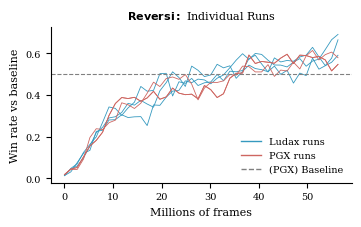

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# parameters
SMOOTH_WINDOW = 5  # or whatever you used before

# build figure
fig, ax = setup_neurips_plot()

for df, label, color in zip([ldx_win_df, pgx_win_df], ["Ludax", "PGX"], colors[:2]):

    # plot raw runs
    for run in df.columns:
        ax.plot(df.index * FRAME_MULTIPLE / 10**6, df[run], alpha=1, color=color, linestyle="-", linewidth=0.6)

raw_legend_lines = [
    Line2D([0], [0], color=colors[0], linewidth=1, linestyle="-", alpha=1, label="Ludax runs"),
    Line2D([0], [0], color=colors[1], linewidth=1, linestyle="-", alpha=1, label="PGX runs"),
    Line2D([0], [0], color="gray", linewidth=1, linestyle="--", alpha=1, label="(PGX) Baseline"),
]
handles, labels = ax.get_legend_handles_labels()
handles.extend(raw_legend_lines)

# Set the legend

# PGX baseline
ax.axhline(0.5, linestyle="--", color="gray", alpha=1, linewidth=0.8)

# labels & legend
ax.set_xlabel("Millions of frames")
ax.set_ylabel("Win rate vs baseline")
ax.set_title("$\\bf{Reversi}:$ Individual Runs")
ax.legend(handles=handles, loc="lower right", framealpha=0.9)
fig.savefig("../data/rl_runs/reversi/reversi_win_raw_runs_frames.pdf", bbox_inches="tight")

plt.show()


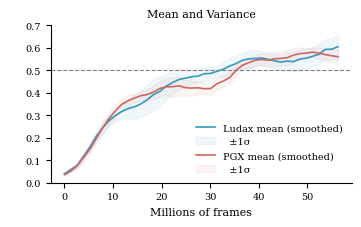

In [ ]:

# ——————————————————————————————————————————————————————
# Now plot Win Rate **vs** Training Time (hours)
fig, ax = setup_neurips_plot()

for win_df, label, color in zip(
    [ldx_win_df, pgx_win_df],
    ["Ludax", "PGX"],
    colors[:2]
):
    # a) compute per-step mean & var of win rate
    mean_raw   = win_df.mean(axis=1)
    var_raw    = win_df.var(axis=1)
    mean_smooth= mean_raw.rolling(window=SMOOTH_WINDOW, min_periods=1, center=True).mean()
    std_smooth = np.sqrt(var_raw.rolling(window=SMOOTH_WINDOW, min_periods=1, center=True).mean())

    frames = df.index * FRAME_MULTIPLE / 10**6

    # c) plot the smoothed mean vs time
    ax.plot(frames, mean_smooth, color=color, label=f"{label} mean (smoothed)")
    
    # d) shade ±1σ around it
    lower = mean_smooth - std_smooth
    upper = mean_smooth + std_smooth
    ax.fill_between(frames, lower, upper,
                    color=color, alpha=0.07,
                    label=f"  ±1σ")

# PGX baseline
ax.axhline(0.5, linestyle="--", color="gray", alpha=1, linewidth=0.8) #

# y limit
ax.set_ylim(0, 0.7)

# labels & legend
ax.set_xlabel("Millions of frames")
ax.set_ylabel("         ")
ax.set_title("Mean and Variance")
ax.legend(loc="lower right", framealpha=0.9)

fig.savefig("../data/rl_runs/reversi/reversi_win_mean_frames.pdf", bbox_inches="tight")
plt.show()

In [25]:
ldx_time = (3.0402630150318153 + 2.944597161942057 + 2.935502486427628) / 3
pgx_time = (2.9331635726822736 + 2.9284172223011655 + 2.9263961433039767) / 3
print(f"Ludax time: {ldx_time:.2f} hours")
print(f"PGX time: {pgx_time:.2f} hours")

print(f"Ludax is {(ldx_time - pgx_time) / pgx_time * 100:.2f}% slower than PGX")

Ludax time: 2.97 hours
PGX time: 2.93 hours
Ludax is 1.51% slower than PGX
